## Assignment for Module 6

In this assignment you will continue working with the housing price per district from the previous module assignment, this time training SVM models, both for regression and classification.

#### Getting the data for the assignment (similar to the notebook from chapter 2 of Hands-On...)

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
housing = load_housing_data()

### Fix the categories in the categorical variable

In [6]:
d = {'<1H OCEAN':'LESS_1H_OCEAN', 'INLAND':'INLAND', 'ISLAND':'ISLAND', 'NEAR BAY':'NEAR_BAY', 'NEAR OCEAN':'NEAR_OCEAN'}
housing['ocean_proximity'] = housing['ocean_proximity'].map(lambda s: d[s])

### Add 2 more features

In [7]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["population_per_household"]=housing["population"]/housing["households"]

### Fix missing data

In [8]:
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True) 

### Create dummy variables based on the categorical variable

In [9]:
one_hot = pd.get_dummies(housing['ocean_proximity'])
housing = housing.drop('ocean_proximity', axis=1)
housing = housing.join(one_hot)

### Check the data

In [10]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 16 columns):
longitude                   20640 non-null float64
latitude                    20640 non-null float64
housing_median_age          20640 non-null float64
total_rooms                 20640 non-null float64
total_bedrooms              20640 non-null float64
population                  20640 non-null float64
households                  20640 non-null float64
median_income               20640 non-null float64
median_house_value          20640 non-null float64
rooms_per_household         20640 non-null float64
population_per_household    20640 non-null float64
INLAND                      20640 non-null uint8
ISLAND                      20640 non-null uint8
LESS_1H_OCEAN               20640 non-null uint8
NEAR_BAY                    20640 non-null uint8
NEAR_OCEAN                  20640 non-null uint8
dtypes: float64(11), uint8(5)
memory usage: 1.8 MB


### Partition into train and test

Use train_test_split from sklearn.model_selection to partition the dataset into 70% for training and 30% for testing.

You can use the 70% for training set as both training and validation by using cross-validation.


In [11]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.3, random_state=42)

### Features

In [12]:
target = 'median_house_value'
features = list(train_set.columns)
features = [f for f in features if f!=target]

In [13]:
X_tr = train_set[features]
y_tr = train_set[[target]]

X_te = test_set[features]
y_te = test_set[[target]]

### Scaling features

Similarly, use StandardScaler from sklearn.preprocessing to normalize the training and testing data, using the training data

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_tr)
X_tr = scaler.transform(X_tr)
X_te = scaler.transform(X_te)

#### Comparing models

In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import numpy as np

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())

### Linear regression on original features (no transformations) --- benchmark

In [16]:
from sklearn.linear_model import LinearRegression
lin_scores = cross_val_score(LinearRegression(), train_set[features], train_set[target], scoring="neg_mean_squared_error", cv=4)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [70142.55721218 67456.39127204 67318.3258893  70866.26065275]
Mean: 68945.88375656835


### 1. Support Vector Machines for Regression

#### (a) In this exercise your goal is to tune SVR with FBR kernel, and make the average score mean_squared_error over 3-folds (cv=3) below 58000. 

You are encouraged to try optimizing any of the hyper-parameters of SVR

See http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html for more details

However, as a hint, you can focus on C and gamma. 

Hint 2: if when you try different values for a hyper-parameter, the optimal models corresponds to one of the extreme values in your range, that probably means you can keep improving your solution by considering values beyond the current range.



In [58]:
def plot_cv_results(cv_results):
    """
    Helper method for plotting the cross validation results for hyper parameter fitting of the 
    Support Vector Regression.
    
    For each unique epsilon create a heat map where the y axis is the C values and the x axis is the gamma value.
    
    The value in the heat map cells if the mean root mean square error for all the cross validation runs. 
    Having a lower scores means that parameter combination performed better than combinations with higher scores.
    """
    
    # For regression we need to convert back to the normal root mean square error
    test_scores = np.sqrt([r*-1 for r in cv_results['mean_test_score']])
        
    # Keep track of the global max and min scores so the heat maps can use the same range
    min_score = np.min(test_scores)
    max_score = np.max(test_scores)
    
    # Pull out all the parameters
    params = cv_results['params']
    gammas = [p['gamma'] for p in params]
    C = [p['C'] for p in params]
    epsilons = [p['epsilon'] for p in params]
    
    results = []
    for index, p in enumerate(params):
        score = test_scores[index]
        results.append([p['gamma'], p['C'], p['epsilon'], score])
    df = pd.DataFrame(results, columns = ['gamma', 'C', 'epsilon', 'score'])
    
    fig, axes = plt.subplots(1,3, figsize=(15,5))
    
    for index, e in enumerate(np.unique(epsilons)):
        # Grab all the rows that correspond to the current epsiolon and print on their own heat map
        rows = df[df['epsilon'] == e]
        scores = rows['score']
        _c = np.unique(rows['C'].values)
        _gammas = np.unique(rows['gamma'].values)    
        reshape_scores = scores.values.reshape(-1,len(_gammas))
        
        ax = axes[index]
        ax = sns.heatmap(reshape_scores, 
                         cbar=index == len(np.unique(epsilons)) -1 ,
                         xticklabels=_gammas, 
                         yticklabels=_c, 
                         ax=ax, 
                         vmin=min_score, 
                         vmax=max_score)
        
        ax.set_xlabel("Gamma")
        ax.set_ylabel("C")
        ax.set_title("epsilon = {}".format(e))

In [18]:
from sklearn.svm import SVR
C_vals = [10, 1000, 10000, 1000000, 10000000]
gamma_vals = [0.01, 0.1, 1]
epsilon = [ 0.01, 0.1, 1]

param_grid = [{'C':C_vals, 'gamma':gamma_vals, 'epsilon':epsilon}]
# Raised the tolerance and set a max_iter so higher C values would finish
grid_search_rbf = GridSearchCV(SVR(kernel='rbf', tol=0.5, max_iter=500000), 
                               param_grid, 
                               cv=3,
                               scoring='neg_mean_squared_error', 
                               return_train_score=True, 
                               n_jobs=2)
grid_search_rbf.fit(X_tr, np.ravel(y_tr))

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=500000, shrinking=True,
  tol=0.5, verbose=False),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid=[{'C': [10, 1000, 10000, 1000000, 10000000], 'gamma': [0.01, 0.1, 1], 'epsilon': [0.01, 0.1, 1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

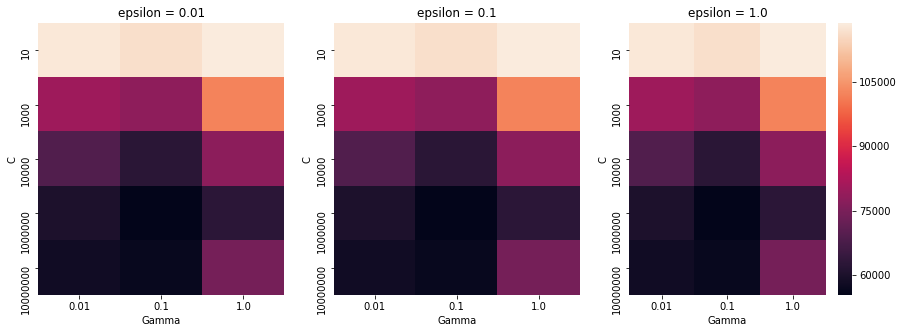

In [59]:
plot_cv_results(grid_search_rbf.cv_results_)

### Observations

It appears *epsilon* doesn't have much of an impact on the models performance with 1 having marginally better results than other parameters.

*Gamma* had more of an impact and was optimized at 0.1.

*C* had the most impact on the performance and was optimized ~1000000.

In [20]:
print(grid_search_rbf.best_params_)
print(np.sqrt(-grid_search_rbf.best_score_))

{'C': 1000000, 'epsilon': 1, 'gamma': 0.1}
55421.563095880345


### Performance on Test Set

In [21]:
from sklearn.metrics import mean_squared_error

final_model = grid_search_rbf.best_estimator_   ## THIS SHOULD BE THE BEST GRID_SEARCH ##

y_te_estimation = final_model.predict(X_te)

final_mse = mean_squared_error(y_te, y_te_estimation)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

54175.0722558122


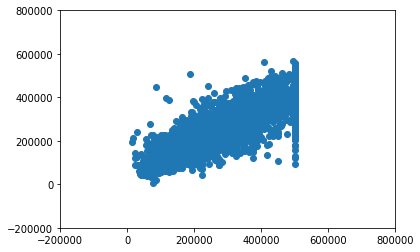

In [22]:
import matplotlib.pyplot as plt

plt.scatter(x=y_te, y=y_te_estimation)
plt.xlim([-200000,800000])
plt.ylim([-200000,800000])
plt.show()

### Observations

The optimized Support Vector Regressor got final root mean square error of **54175.07** which was much better than the Linear Regression score of **68945.88**

### 2. SVM for Classification

Now we transform the continuous target into a binary variable, indicating whether or not the price is above the average $179700


In [48]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [24]:
np.median(housing[['median_house_value']])

179700.0

#### Binary target variable

In [25]:
y_tr_b = 1*np.ravel(y_tr>=179700.0)
y_te_b = 1*np.ravel(y_te>=179700.0)

#### Linear SVM for classification

In [85]:
from sklearn.svm import LinearSVC

In [86]:
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_tr, y_tr_b)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

In [89]:
y_pred = lin_clf.predict(X_tr)
linear_accuracy = accuracy_score(y_tr_b, y_pred)
linear_precision = precision_score(y_tr_b, y_pred)
linear_recall = recall_score(y_tr_b, y_pred)
print('Accuracy of Linear SVC: {}'.format(linear_accuracy))
print('Precision of Linear SVC: {}'.format(linear_precision))
print('Recall of Linear SVC: {}'.format(linear_recall))

Accuracy of Linear SVC: 0.8385935769656699
Precision of Linear SVC: 0.8329003145084097
Recall of Linear SVC: 0.8458547423968893


### (a) Does SVC (with default hyper-parameters) improve the performance of the linear SVM?

In [68]:
from sklearn.svm import SVC

In [91]:
svc = SVC()
svc.fit(X_tr, y_tr_b)
y_pred = svc.predict(X_tr)
default_accuracy = accuracy_score(y_tr_b, y_pred)
default_precision = precision_score(y_tr_b, y_pred)
default_recall = recall_score(y_tr_b, y_pred)
print('Accuracy of default SVC: {}'.format(default_accuracy))
print('Precision of default SVC: {}'.format(default_precision))
print('Recall of default SVC: {}'.format(default_recall))

Accuracy of default SVC: 0.866140642303433
Precision of default SVC: 0.8677559000139645
Recall of default SVC: 0.8629357033745313


### Observations

The Support Vector Classifier with default parameters obtained an accuracy score of **0.866** compared to the **0.838** score of the LinearSVC.

It also had improved precision (0.86 > 0.83) and recall (0.86 > 0.85) as well.

### (b) Use randomized search to tune hyper-parameters of SVC and improve its performance

In [79]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

In [80]:
def plot_random_results(cv_results):
    """
    Plot the cross validation results for the Randomized Search for the Support Vector Classifier as a scatter plot.
    
    On the x axis show the different C values and on the y axis show the different gamma values. The color and size 
    of the scatter points represents the accuracy for that particular combination. The larger/darker the dot the
    better that particular model preformed.
    """
    
    scores = cv_results['mean_test_score']
    params = cv_results['params']
    
    results = []
    for param, r in zip (params, scores):
        c = param['C']
        gamma = param['gamma']
        results.append([c, gamma, r])
        
    df = pd.DataFrame(results, columns = ['C', 'gamma', 'score'])
    df = df.sort_values(by=['C', 'gamma'])
    
    cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
    plt.subplots(figsize=(15,7))
    sns.scatterplot(x="C", y="gamma", size="score", hue="score", data=df)

In [81]:
param_dist = {"C": uniform(0.01, 40),
              "gamma": uniform(0.01, 0.6)}

random_search = RandomizedSearchCV(SVC(), param_distributions=param_dist,
                                   return_train_score=True,
                                   n_iter=100, 
                                   cv=3,
                                   n_jobs=4)

random_search.fit(X_tr, np.ravel(y_tr_b))

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=4,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x10b478e80>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x10b478240>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

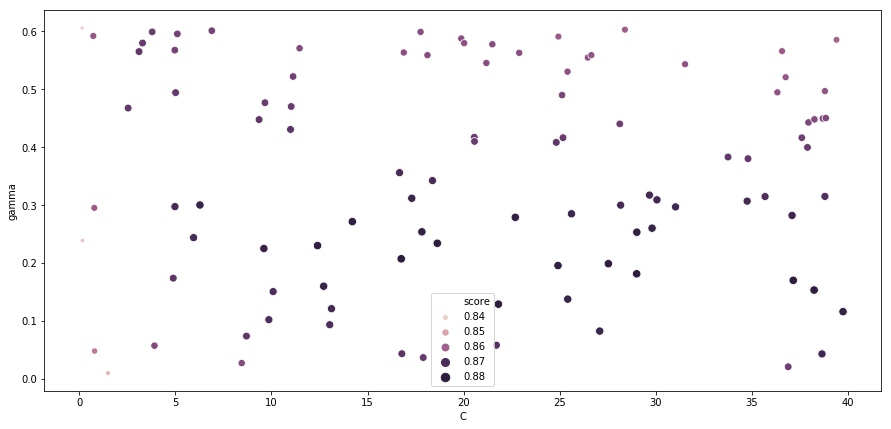

In [82]:
plot_random_results(random_search.cv_results_)

### Observations

After 100 iterations the best performing models tended to be those with with *gamma* in the range of ~0.1 to ~0.3
and *C* values in the range 15 to 40. 

The best performing model had a *gamma* of 0.15 and *C* value of 38.24.

In [83]:
print(random_search.best_params_)
print(random_search.best_score_)

{'C': 38.24096284379315, 'gamma': 0.15344258089414672}
0.8733388704318937


In [95]:
y_pred = random_search.best_estimator_.predict(X_tr)

optimized_accuracy = accuracy_score(y_tr_b, y_pred)
optimized_precision = precision_score(y_tr_b, y_pred)
optimized_recall = recall_score(y_tr_b, y_pred)

print('Accuracy of optimized SVC: {}'.format(optimized_accuracy))
print('Precision of optimized SVC: {}'.format(optimized_precision))
print('Recall of optimized SVC: {}'.format(optimized_recall))

Accuracy of optimized SVC: 0.9102990033222591
Precision of optimized SVC: 0.913689225164635
Recall of optimized SVC: 0.9055686710179142


In [98]:
df = pd.DataFrame([[linear_accuracy, linear_precision, linear_recall],
                  [default_accuracy, default_precision, default_recall],
                  [optimized_accuracy, optimized_precision, optimized_recall]], 
                  columns=['Accuracy', 'Precision', 'Recall'],
                 index=["Linear SVC", "Default SVC", "Optimized SVC"])
df.T

,Linear SVC,Default SVC,Optimized SVC
Accuracy,0.838594,0.866141,0.910299
Precision,0.832900,0.867756,0.913689
Recall,0.845855,0.862936,0.905569


### Observations

Unsurprisingly, the SVC with the parameters obtained through randomized cross validation search performed better on accuracy, precision and recall than both the Linear SVC as well as the SVC with default parameters.

Simply optimizing the parameters of the SVC increased the accuracy from 86.6% to 96%.